<a href="https://colab.research.google.com/github/mikethisyamondol/ames_housing_price/blob/main/Ames_IA_Housing_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Ames Housing Price Data
<br>
<br>
Mike Thisyamondol

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

#### **Ingest**

In [2]:
# Import train/test data
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download house-prices-advanced-regression-techniques

test.csv: Skipping, found more recently modified local copy (use --force to force download)
data_description.txt: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

#### **EDA**

In [8]:
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

In [9]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [11]:
df_train.isnull().sum()[df_train.isnull().sum() > 0].sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [12]:
df_test.isnull().sum()[df_test.isnull().sum() > 0].sort_values(ascending=False)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageCond        78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

##### Investigate/Impute Null Values:

At first glance, it seems as though there is a significant amount of null values for certain features, but after close inspection of the data_description.txt file, a lot of the null values correspond to the houses not having the feature such as a pool, alley, fence, etc. Because of this, we can potentially replace null values with 'NA' after a bit of validation.

Columns where null = NA/0:

- PoolQC
- MiscFeature
- Alley
- Fence
- FireplaceQu
- GarageType
- GarageFinish
- GarageQual
- GarageCond
- BsmtFinType2
- BsmtExposure
- BsmtFinType1
- BsmtCond
- BsmtQual

Some null values might not be worth the effort especially if it will not be a strong predictor in price. Let's first address the features that we're more confident we can replace null with NA such as PoolQC, MiscFeature, Alley, Fence, and FireplaceQu.

In [13]:
# Pool Check
df_train[df_train['PoolQC'].isnull()]['PoolArea'].sum()

0

In [14]:
df_test[df_test['PoolQC'].isnull()]['PoolArea'].sum()

1373

In [15]:
df_test[(df_test['PoolQC'].isnull()) & (df_test['PoolArea'] > 0)][['PoolQC', 'PoolArea']]

,PoolQC,PoolArea
960,NaN,368
1043,NaN,444
1139,NaN,561


In [16]:
# Replace PoolQC null values that have PoolArea > 0 as TA (Average/Typical)
index = df_test[(df_test['PoolQC'].isnull()) & (df_test['PoolArea'] > 0)].index
df_test.loc[index, 'PoolQC'] = 'TA'

In [17]:
# Replace PoolQC null values with 'NA'
df_train['PoolQC'] = df_train['PoolQC'].fillna("NA")
df_test['PoolQC'] = df_test['PoolQC'].fillna("NA")

In [18]:
# MiscFeatures Check
df_train[df_train['MiscFeature'].isnull()]['MiscVal'].sum()

0

In [19]:
df_test[df_test['MiscFeature'].isnull()]['MiscVal'].sum()

17000

In [20]:
df_test[(df_test['MiscFeature'].isnull()) & (df_test['MiscVal'] > 0)][['MiscFeature', 'MiscVal']]

,MiscFeature,MiscVal
1089,NaN,17000


In [21]:
index = df_test[(df_test['MiscFeature'].isnull()) & (df_test['MiscVal'] > 0)].index
df_test.loc[index, 'MiscFeature'] = 'Othr'

In [22]:
# Replace MiscFeatures null values with 'NA'
df_train['MiscFeature'] = df_train['MiscFeature'].fillna("NA")
df_test['MiscFeature'] = df_test['MiscFeature'].fillna("NA")

In [23]:
# Alley
# Replace Alley null values with 'NA'
df_train['Alley'] = df_train['Alley'].fillna("NA")
df_test['Alley'] = df_test['Alley'].fillna("NA")

In [24]:
# Fence
# Replace Fence null values with 'NA'
df_train['Fence'] = df_train['Fence'].fillna("NA")
df_test['Fence'] = df_test['Fence'].fillna("NA")

In [25]:
# FireplaceQu
# Replace Fence null values with 'NA'
df_train['FireplaceQu'] = df_train['FireplaceQu'].fillna("NA")
df_test['FireplaceQu'] = df_test['FireplaceQu'].fillna("NA")

In [26]:
# Garage variables
garage_columns = [col for col in df_train if "Garage" in col]
garage_columns

['GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond']

In [27]:
df_train[(df_train['GarageCond'].isnull()) & (df_train['GarageArea'] > 0)][garage_columns]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond


In [28]:
df_test[(df_test['GarageQual'].isnull()) & (df_test['GarageType'].notnull())][garage_columns]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
666,Detchd,NaN,NaN,1.0,360.0,NaN,NaN
1116,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df_test[df_test['GarageType'] == 'Detchd']['GarageFinish'].mode()

0    Unf
dtype: object

In [30]:
df_test[df_test['GarageType'] == 'Detchd']['GarageCars'].mode()

0    1.0
dtype: float64

In [31]:
df_test[df_test['GarageType'] == 'Detchd']['GarageArea'].mean()

412.2020460358056

In [32]:
df_test[df_test['GarageType'] == 'Detchd']['GarageQual'].mode()

0    TA
dtype: object

In [33]:
df_test[df_test['GarageType'] == 'Detchd']['GarageCond'].mode()

0    TA
dtype: object

In [34]:
df_test[['YearBuilt', 'GarageYrBlt']]

,YearBuilt,GarageYrBlt
0,1961,1961.0
1,1958,1958.0
2,1997,1997.0
3,1998,1998.0
4,1992,1992.0
...,...,...
1454,1970,NaN
1455,1970,1970.0
1456,1960,1960.0
1457,1992,NaN


In [35]:
yr_diff = df_test['GarageYrBlt'] - df_test['YearBuilt']
yr_diff.median()

0.0

In [36]:
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].fillna(df_train['YearBuilt'])
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].fillna(df_train['YearBuilt'])

In [37]:
index1 = df_test[(df_test['GarageQual'].isnull()) & (df_test['GarageArea'] > 0)][garage_columns].index 
index2 = df_test[(df_test['GarageQual'].isnull()) & (df_test['GarageArea'].isnull())][garage_columns].index 

In [38]:
# GarageFinish
df_test.loc[index1, 'GarageFinish'] = 'Unf'
df_test.loc[index2, 'GarageFinish'] = 'Unf'

# GarageQual
df_test.loc[index1, 'GarageQual'] = 'TA'
df_test.loc[index2, 'GarageQual'] = 'TA'

#GarageCond
df_test.loc[index1, 'GarageCond'] = 'TA'
df_test.loc[index2, 'GarageCond'] = 'TA'

# GarageArea
df_test.loc[index2, 'GarageArea'] = df_test[df_test['GarageType'] == 'Detchd']['GarageArea'].mean()

# GarageCars
df_test.loc[index2, 'GarageCars'] = 1.0

In [39]:
# Fill Categorical data with NA, fill numericals with 0
garage_col_cat = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
garage_col_num = ['GarageCars', 'GarageArea', 'GarageYrBlt']

In [40]:
for col in garage_col_cat:
    df_train[col] = df_train[col].fillna("NA")
    df_test[col] = df_test[col].fillna("NA")

In [41]:
# Basement Variables
bsmt_columns = [col for col in df_train if "Bsmt" in col]
bsmt_columns

['BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath']

In [42]:
df_train[df_train['BsmtCond'].isnull()]['TotalBsmtSF'].sum()

0

In [43]:
df_test[df_test['BsmtQual'].isnull()]['TotalBsmtSF'].sum()

529.0

In [44]:
df_test[(df_test['BsmtCond'].isnull()) & (df_test['TotalBsmtSF'] > 0)][bsmt_columns]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
580,Gd,NaN,Mn,GLQ,1044.0,Rec,382.0,0.0,1426.0,1.0,0.0
725,TA,NaN,No,BLQ,1033.0,Unf,0.0,94.0,1127.0,0.0,1.0
1064,TA,NaN,Av,ALQ,755.0,Unf,0.0,240.0,995.0,0.0,0.0


In [45]:
index = df_test[(df_test['BsmtCond'].isnull()) & (df_test['TotalBsmtSF'] > 0)].index
df_test.loc[index, 'BsmtCond'] = df_test.loc[index, 'BsmtQual']

In [46]:
df_test[(df_test['BsmtQual'].isnull()) & (df_test['TotalBsmtSF'] > 0)][bsmt_columns]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
757,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,0.0,0.0
758,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,0.0,0.0


In [47]:
index = df_test[(df_test['BsmtQual'].isnull()) & (df_test['TotalBsmtSF'] > 0)].index 
df_test.loc[index, 'BsmtQual'] = df_test.loc[index, 'BsmtCond']

In [48]:
df_train[(df_train['BsmtFinType2'].isnull()) & (df_train['BsmtQual'].notnull())][bsmt_columns]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
332,Gd,TA,No,GLQ,1124,NaN,479,1603,3206,1,0


In [49]:
index = df_train[(df_train['BsmtFinType2'].isnull()) & (df_train['BsmtQual'].notnull())].index 
df_test.loc[index, 'BsmtFinType2'] = df_test.loc[index, 'BsmtFinType1']

In [50]:
# Fill Categorical data with NA, fill numericals with 0
bsmt_col_cat = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',]
bsmt_col_num = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF','BsmtFullBath', 'BsmtHalfBath']

In [51]:
for col in bsmt_col_cat:
    df_train[col] = df_train[col].fillna("NA")
    df_test[col] = df_test[col].fillna("NA")

In [52]:
for col in bsmt_col_num:
    df_test[col] = df_test[col].fillna(0)

In [53]:
# Lot Frontage
lot_columns = [col for col in df_train if "Lot" in col]
df_train[lot_columns].head()

,LotFrontage,LotArea,LotShape,LotConfig
0,65.0,8450,Reg,Inside
1,80.0,9600,Reg,FR2
2,68.0,11250,IR1,Inside
3,60.0,9550,IR1,Corner
4,84.0,14260,IR1,FR2


In [54]:
df_test[lot_columns].head()

,LotFrontage,LotArea,LotShape,LotConfig
0,80.0,11622,Reg,Inside
1,81.0,14267,IR1,Corner
2,74.0,13830,IR1,Inside
3,78.0,9978,IR1,Inside
4,43.0,5005,IR1,Inside


In [55]:
df_train['LotFrontage'] = df_train[['LotFrontage']].fillna(df_train.groupby('LotConfig').transform('mean'))
df_test['LotFrontage'] = df_test[['LotFrontage']].fillna(df_test.groupby('LotConfig').transform('mean'))

In [56]:
#MasVnrArea + MasVnrType
df_train[df_train['MasVnrType'].isnull()][['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [57]:
df_test[df_test['MasVnrType'].isnull()][['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea
231,NaN,NaN
246,NaN,NaN
422,NaN,NaN
532,NaN,NaN
544,NaN,NaN
581,NaN,NaN
851,NaN,NaN
865,NaN,NaN
880,NaN,NaN
889,NaN,NaN


In [58]:
df_train['MasVnrType'] = df_train['MasVnrType'].fillna("None")
df_train['MasVnrArea'] = df_train['MasVnrArea'].fillna(0)

df_test['MasVnrType'] = df_test['MasVnrType'].fillna("None")
df_test['MasVnrArea'] = df_test['MasVnrArea'].fillna(0)

In [59]:
df_test[df_test['MSZoning'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
455,1916,30,NaN,109.000000,21780,Grvl,NA,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,NA,NA,NA,NA,0.0,NA,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,NA,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,NA,NA,NA,0,3,2009,ConLD,Normal
756,2217,20,NaN,80.000000,14584,Pave,NA,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,NA,NA,NA,NA,0.0,NA,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,NaN,0,NA,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,NA,NA,NA,0,2,2008,WD,Abnorml
790,2251,70,NaN,66.709746,56600,Pave,NA,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,NA,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,NA,NA,NA,0,1,2008,WD,Normal
1444,2905,20,NaN,125.000000,31250,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,TA,Fa,CBlock,NA,NA,NA,NA,0.0,NA,0.0,0.0,0.0,GasA,TA,Y,FuseA,1600,0,0,1600,0.0,0.0,1,1,3,1,TA,6,Mod,0,NA,Attchd,1951.0,Unf,1.0,270.0,Fa,TA,N,0,0,135,0,0,0,NA,NA,NA,0,5,2006,WD,Normal


In [60]:
df_test.groupby('MSSubClass')['MSZoning'].agg(pd.Series.mode)

MSSubClass
20     RL
30     RM
40     RL
45     RM
50     RL
60     RL
70     RM
75     RM
80     RL
85     RL
90     RL
120    RL
150    RL
160    RM
180    RM
190    RL
Name: MSZoning, dtype: object

In [61]:
index1 = df_test[(df_test['MSZoning'].isnull()) & (df_test['MSSubClass'] == 20)].index 
index2 = df_test[(df_test['MSZoning'].isnull()) & (df_test['MSSubClass'] == 30)].index 
index3 = df_test[(df_test['MSZoning'].isnull()) & (df_test['MSSubClass'] == 70)].index 

In [62]:
df_test.loc[index1, 'MSZoning'] = 'RL'
df_test.loc[index2, 'MSZoning'] = 'RM'
df_test.loc[index3, 'MSZoning'] = 'RM'

In [63]:
df_test[df_test['Functional'].isnull()][['OverallCond', 'Functional']]

,OverallCond,Functional
756,5,NaN
1013,1,NaN


In [64]:
df_test.groupby('OverallCond')['Functional'].agg(pd.Series.mode)

OverallCond
1    Maj1
2     Typ
3     Typ
4     Typ
5     Typ
6     Typ
7     Typ
8     Typ
9     Typ
Name: Functional, dtype: object

In [65]:
index = df_test[df_test['Functional'].isnull()].index
df_test.loc[index, 'Functional'] = 'Typ'

In [66]:
df_test['Utilities'].mode()

0    AllPub
dtype: object

In [67]:
index = df_test[df_test['Utilities'].isnull()].index
df_test.loc[index, 'Utilities'] = 'AllPub'

In [68]:
df_test.groupby('Neighborhood')['SaleType'].agg(pd.Series.mode)

Neighborhood
Blmngtn    WD
Blueste    WD
BrDale     WD
BrkSide    WD
ClearCr    WD
CollgCr    WD
Crawfor    WD
Edwards    WD
Gilbert    WD
IDOTRR     WD
MeadowV    WD
Mitchel    WD
NAmes      WD
NPkVill    WD
NWAmes     WD
NoRidge    WD
NridgHt    WD
OldTown    WD
SWISU      WD
Sawyer     WD
SawyerW    WD
Somerst    WD
StoneBr    WD
Timber     WD
Veenker    WD
Name: SaleType, dtype: object

In [69]:
index = df_test[df_test['SaleType'].isnull()].index
df_test.loc[index, 'SaleType'] = 'WD'

In [70]:
df_test['KitchenQual'].mode()

0    TA
dtype: object

In [71]:
index = df_test[df_test['KitchenQual'].isnull()].index
df_test.loc[index, 'KitchenQual'] = 'TA'

In [72]:
df_test['Exterior2nd'].mode()

0    VinylSd
dtype: object

In [73]:
index = df_test[df_test['Exterior2nd'].isnull()].index
df_test.loc[index, 'Exterior2nd'] = 'VinylSd'

In [74]:
df_test['Exterior1st'].mode()

0    VinylSd
dtype: object

In [75]:
index = df_test[df_test['Exterior1st'].isnull()].index
df_test.loc[index, 'Exterior1st'] = 'VinylSd'

In [76]:
df_train['Electrical'].mode()

0    SBrkr
dtype: object

In [77]:
index = df_train[df_train['Electrical'].isnull()].index
df_train.loc[index, 'Electrical'] = 'SBrkr'

In [78]:
df_test.isnull().sum()[df_test.isnull().sum() > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [79]:
df_train.isnull().sum()[df_train.isnull().sum() > 0].sort_values(ascending=False)

Series([], dtype: int64)

##### Data Exploration/Feature Engineering

In [80]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.026867,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1976.507534,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,22.310010,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,26.306739,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1872.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1959.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,67.715686,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1978.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [81]:
df_test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.387483,9819.161069,6.078821,5.553804,1971.357779,1983.662783,99.673749,438.902673,52.583276,553.915010,1045.400960,1156.534613,325.967786,3.543523,1486.045922,0.433859,0.065113,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1977.359836,1.765593,472.727349,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,20.850996,4955.517327,1.436812,1.113740,30.390071,21.130467,177.001792,455.257119,176.698671,437.351324,443.592976,398.165820,420.610226,44.043251,485.566099,0.530527,0.252307,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,26.770632,0.775938,216.979959,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,1880.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,59.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.000000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.00000,1959.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,66.709746,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.000000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.00000,1979.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,162.000000,752.000000,0.000000,797.500000,1304.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.00000,2002.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.00000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


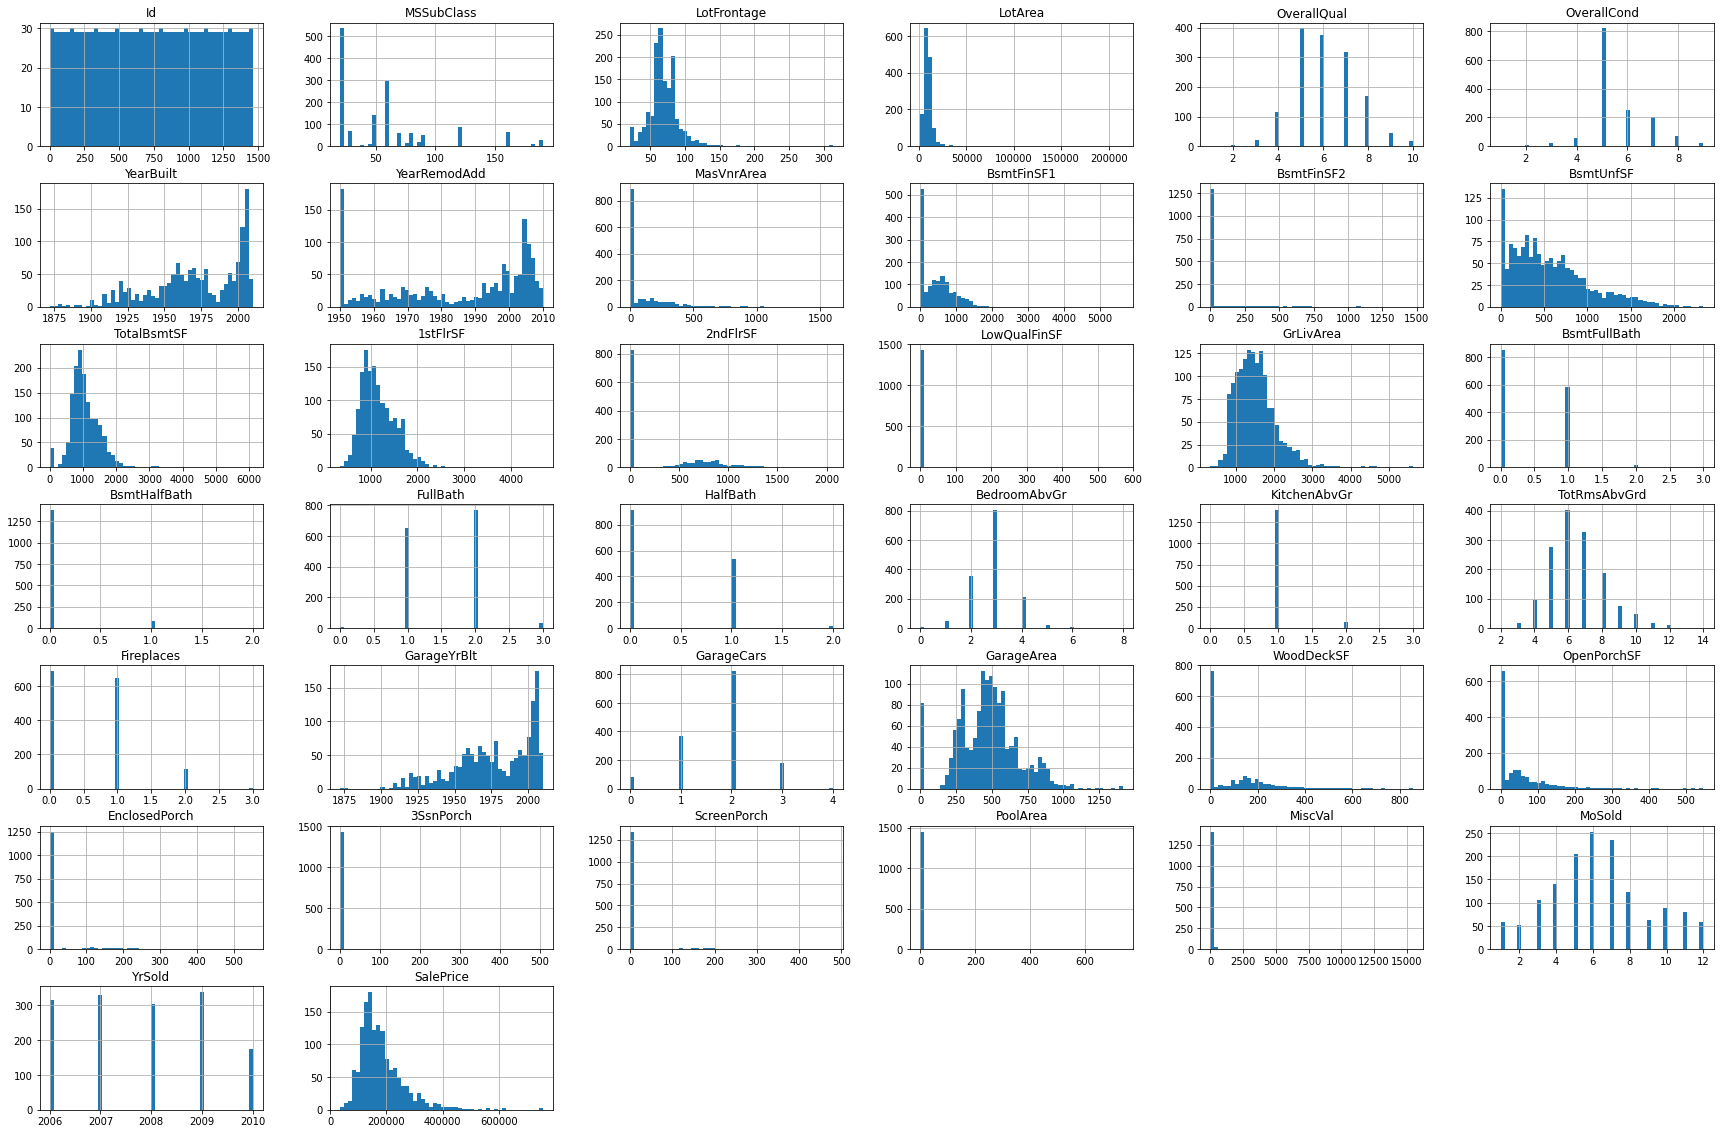

In [82]:
# Variable Distributions
df_train.hist( bins = 50, figsize = (30, 20))
plt.show()

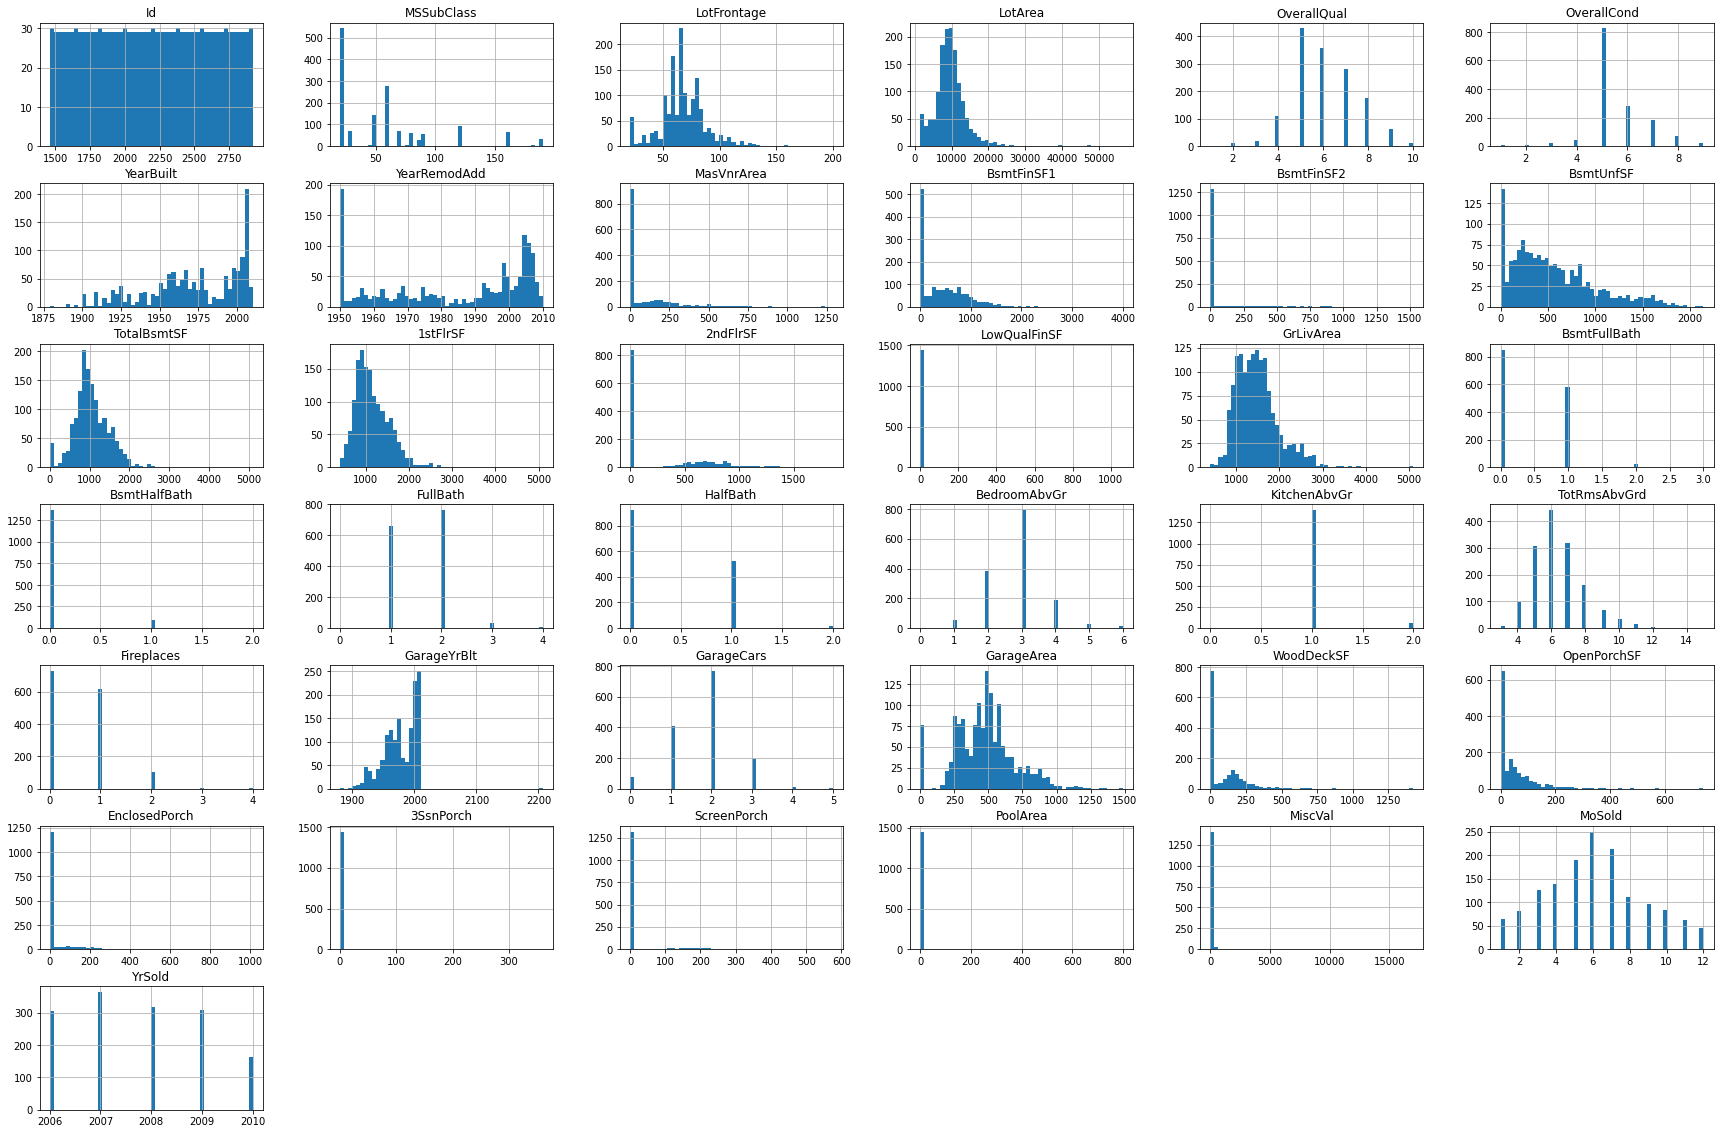

In [83]:
df_test.hist( bins = 50, figsize = (30, 20))
plt.show()

In [84]:
sorted(list(df_train.columns))

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'Alley',
 'BedroomAbvGr',
 'BldgType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtQual',
 'BsmtUnfSF',
 'CentralAir',
 'Condition1',
 'Condition2',
 'Electrical',
 'EnclosedPorch',
 'ExterCond',
 'ExterQual',
 'Exterior1st',
 'Exterior2nd',
 'Fence',
 'FireplaceQu',
 'Fireplaces',
 'Foundation',
 'FullBath',
 'Functional',
 'GarageArea',
 'GarageCars',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'Heating',
 'HeatingQC',
 'HouseStyle',
 'Id',
 'KitchenAbvGr',
 'KitchenQual',
 'LandContour',
 'LandSlope',
 'LotArea',
 'LotConfig',
 'LotFrontage',
 'LotShape',
 'LowQualFinSF',
 'MSSubClass',
 'MSZoning',
 'MasVnrArea',
 'MasVnrType',
 'MiscFeature',
 'MiscVal',
 'MoSold',
 'Neighborhood',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PavedDrive',
 'PoolArea',
 'PoolQC',
 'RoofMatl',
 'RoofStyle

Based off personal experience, there are a number of factors that help determine housing price. The most important factors that come to mind are: Location (neighborhood), building type, square footage/lot area, quality/condition, and additional features such as pools, decks, etc. Other external factors such as when the house can also affect the price as well, the idea being houses sold during a recession would likely have a lower sale price than during other times.

Since this dataset contains these factors broken out into smaller sub features, we can potentially combine a few together to create new features such as total square footage. We can also transform the quality features into ordinal variables, potentially making it easier to perform a regression, instead of creating dummy variables for them.

In [85]:
# Combine SF features to create Total SF
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']
# Combine Bathroom features to create Total Baths
df_train['TotalBaths'] = df_train['FullBath'] + df_train['BsmtFullBath'] + 0.5*(df_train['HalfBath'] + df_train['BsmtHalfBath'])

In [86]:
# Rating Dictionary
rating_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}

# Find all columns that use rating system: Ex, Gd, TA, Fa, Po
rating_columns = [col for col in df_train.columns if df_train[col].sort_values().iloc[0] == 'Ex']

# # Map values using dictionary
for col in rating_columns:
    df_train[col] = df_train[col].map(rating_dict)

Let's take a quick look at our features to see if any contain outliers with a quick visual check.

Text(0.5, 1.0, 'All variables boxplot\n')

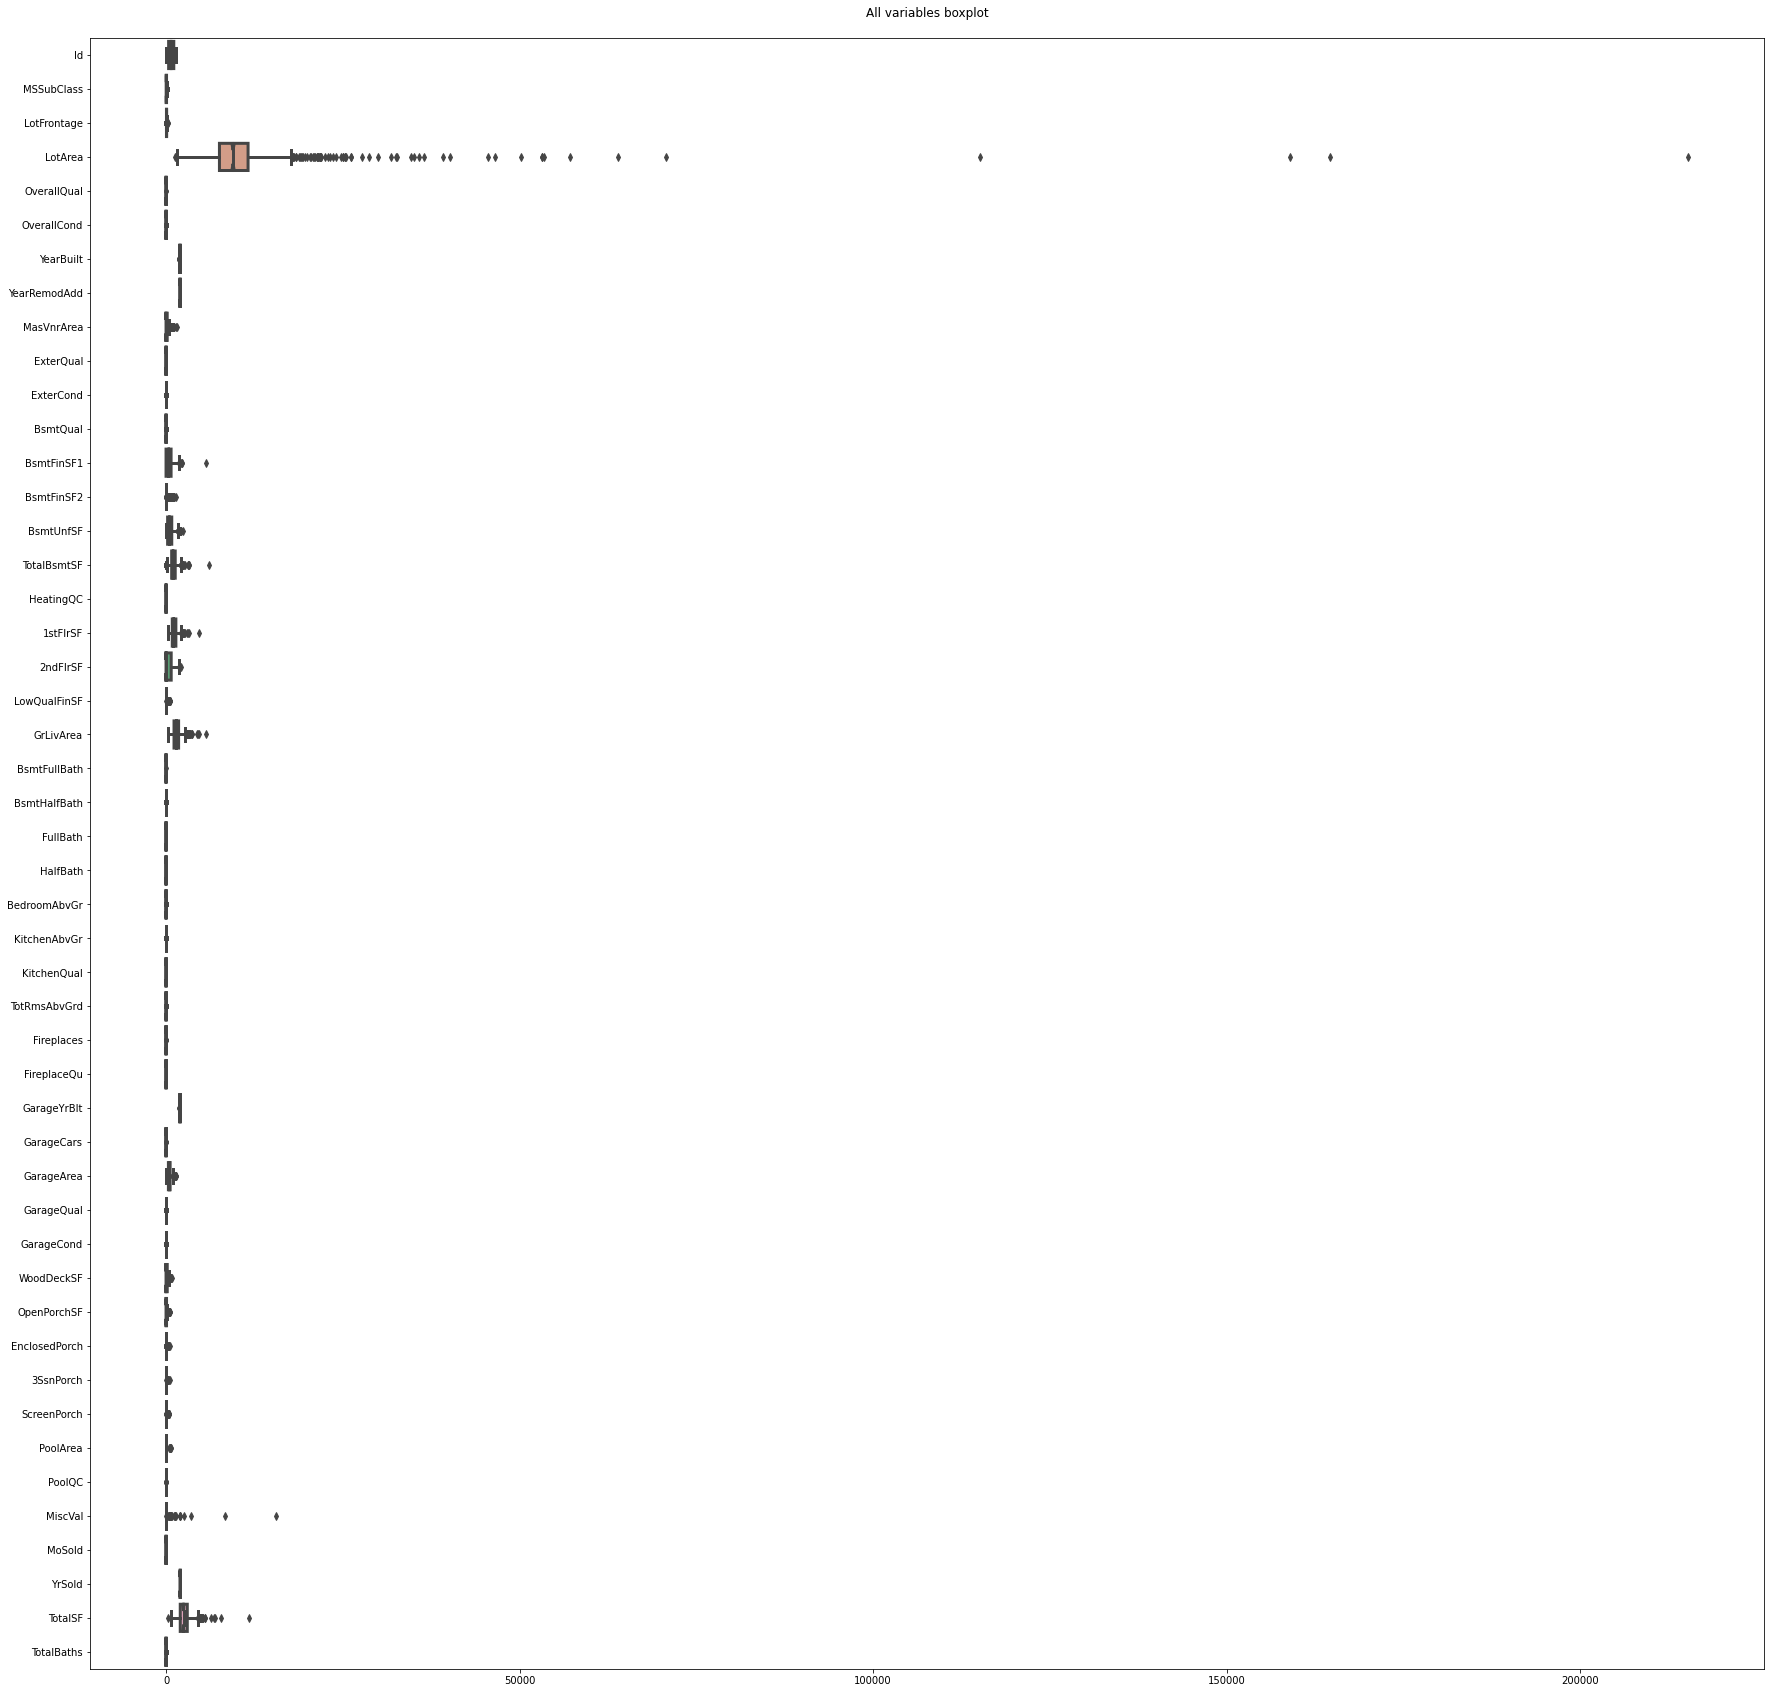

In [87]:
# Quick visual check for outliers:

fig = plt.figure(figsize=(30,30))
ax = fig.gca()

ax = sns.boxplot(data=df_train.loc[:, df_train.columns != 'SalePrice'], orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('All variables boxplot\n')

The above chart is not very informative, but provides a decent quick glance at whether there are any outliers. This and the histogram charts above gives us a decent idea of the shape of the data.

Text(0.5, 1.0, 'Sale Price boxplot\n')

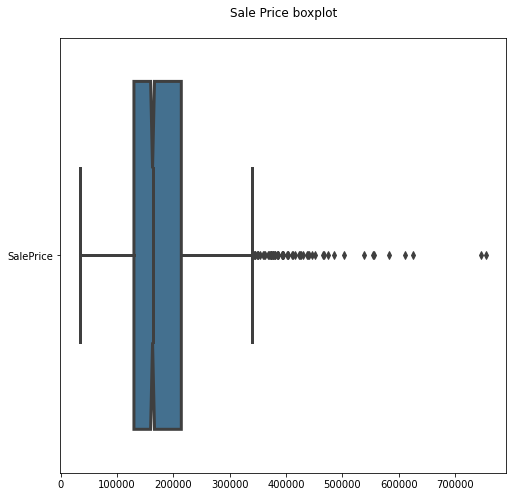

In [88]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax = sns.boxplot(data=df_train.loc[:, df_train.columns == 'SalePrice'], orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('Sale Price boxplot\n')

Text(0.5, 1.0, 'Lot Area boxplot\n')

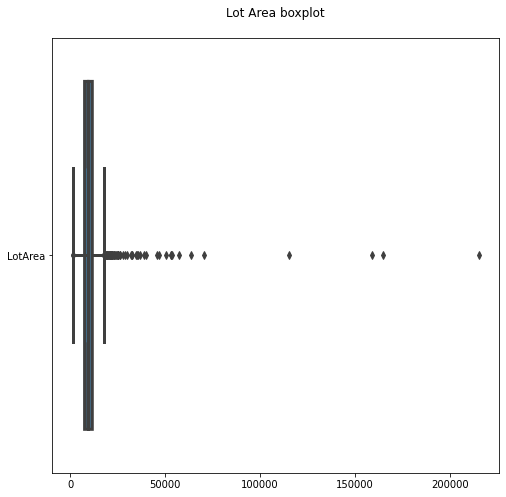

In [89]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax = sns.boxplot(data=df_train.loc[:, df_train.columns == 'LotArea'], orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('Lot Area boxplot\n')

Text(0.5, 1.0, 'BsmtFinSF1 boxplot\n')

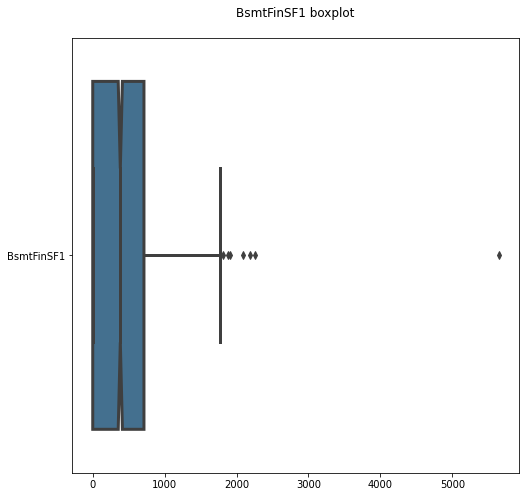

In [90]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax = sns.boxplot(data=df_train.loc[:, df_train.columns == 'BsmtFinSF1'], orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('BsmtFinSF1 boxplot\n')

Text(0.5, 1.0, 'TotalBsmtSF boxplot\n')

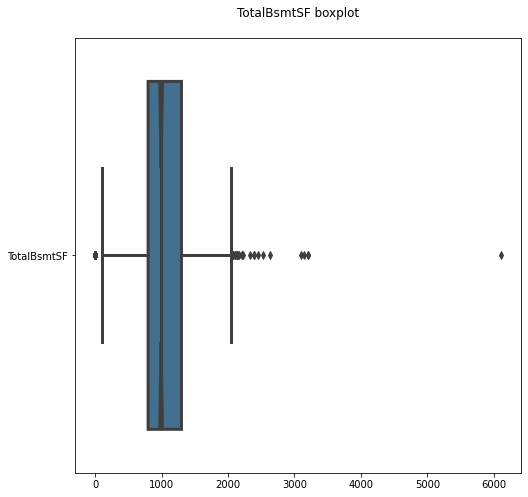

In [91]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax = sns.boxplot(data=df_train.loc[:, df_train.columns == 'TotalBsmtSF'], orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('TotalBsmtSF boxplot\n')

Text(0.5, 1.0, '1stFlrSF boxplot\n')

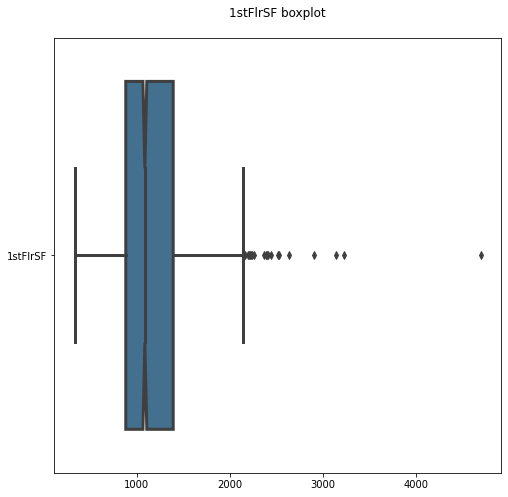

In [92]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax = sns.boxplot(data=df_train.loc[:, df_train.columns == '1stFlrSF'], orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('1stFlrSF boxplot\n')

Text(0.5, 1.0, 'GrLivArea boxplot\n')

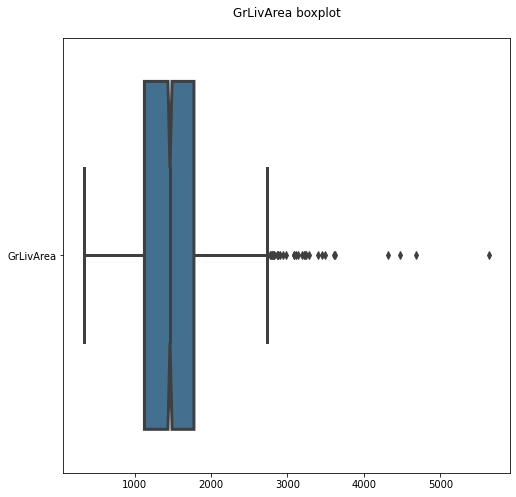

In [93]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax = sns.boxplot(data=df_train.loc[:, df_train.columns == 'GrLivArea'], orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('GrLivArea boxplot\n')

Text(0.5, 1.0, 'MiscVal boxplot\n')

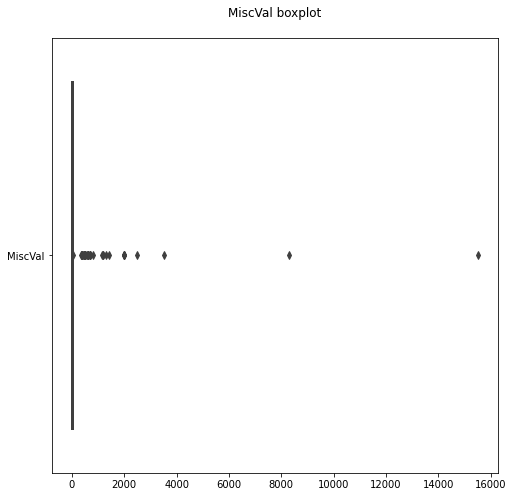

In [94]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax = sns.boxplot(data=df_train.loc[:, df_train.columns == 'MiscVal'], orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('MiscVal boxplot\n')

Text(0.5, 1.0, 'MasVnrArea boxplot\n')

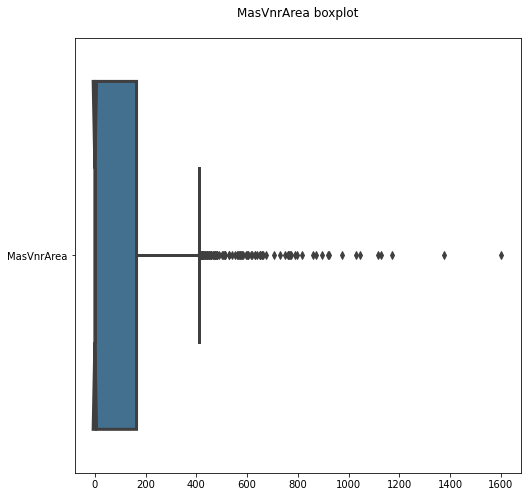

In [95]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax = sns.boxplot(data=df_train.loc[:, df_train.columns == 'MasVnrArea'], orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('MasVnrArea boxplot\n')

Based off of the above boxplots it is hard to determine if these outliers are valid on their own. Let's plot them out against SalePrice to see if they make sense (e.g. a larger house would likely also have a higher sale price in a given area). It would also make sense to take a look at these broken down by neighborhood to help identify other anomalies, the idea being a sensible value in one neighborhood might not be the case for a different one.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


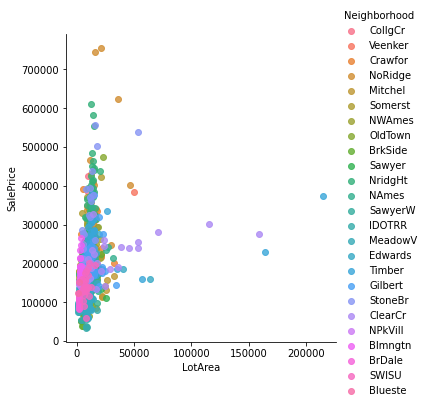

In [96]:
sns.lmplot('LotArea', 'SalePrice', data=df_train, hue='Neighborhood', fit_reg=False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


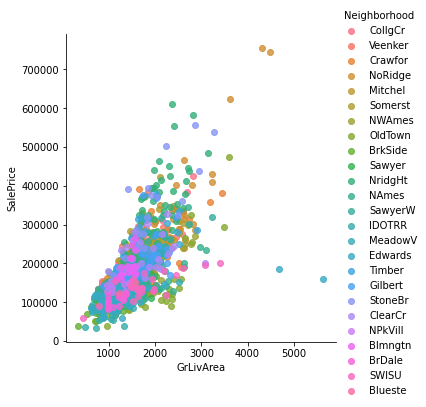

In [97]:
sns.lmplot('GrLivArea', 'SalePrice', data=df_train, hue='Neighborhood', fit_reg=False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


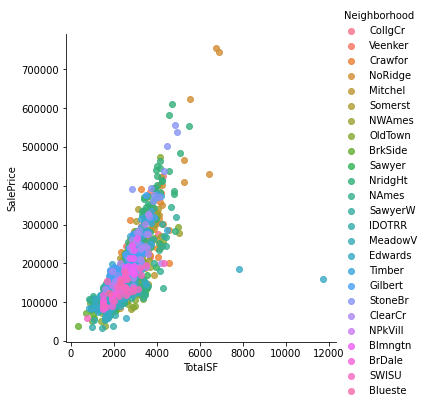

In [98]:
sns.lmplot('TotalSF', 'SalePrice', data=df_train, hue='Neighborhood', fit_reg=False)

Let's see what happens when we remove some of the outliers:

In [99]:
df_train = df_train.drop(df_train[df_train['LotArea'] > 100000].index)
df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 200000)].index)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


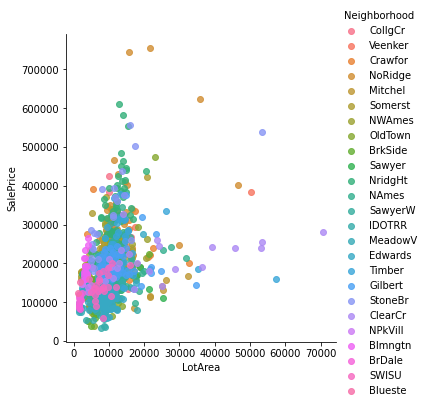

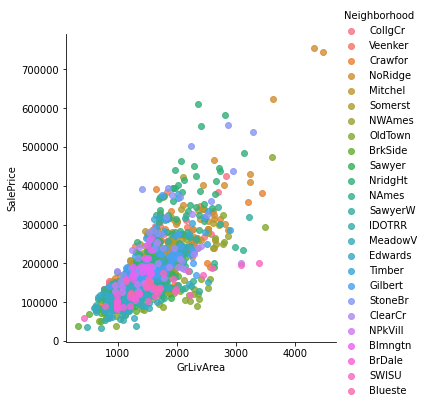

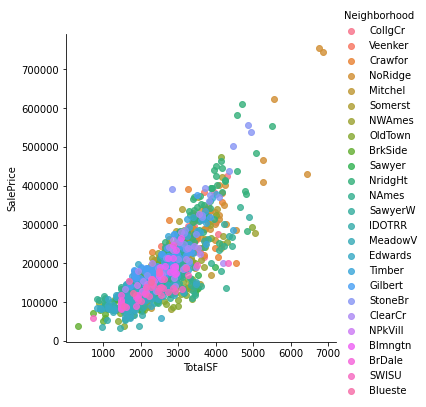

In [100]:
sns.lmplot('LotArea', 'SalePrice', data=df_train, hue='Neighborhood', fit_reg=False)
sns.lmplot('GrLivArea', 'SalePrice', data=df_train, hue='Neighborhood', fit_reg=False)
sns.lmplot('TotalSF', 'SalePrice', data=df_train, hue='Neighborhood', fit_reg=False)

In addition to square footage/lot area, it makes intuitive sense that the overall quality of the home, and the neighborhood would be good predictors of housing price.

Text(0.5, 1.0, 'OverallQual by SalePrice boxplot\n')

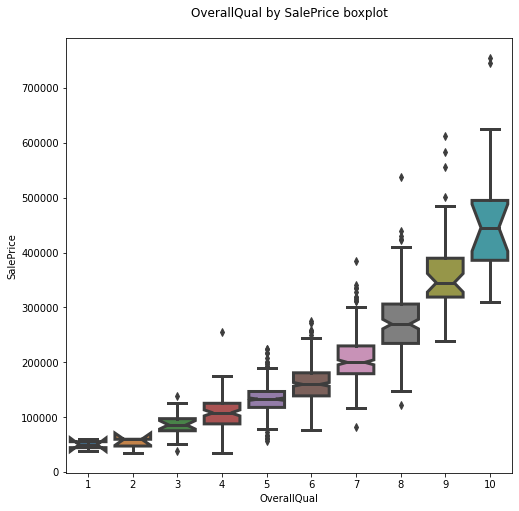

In [101]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax = sns.boxplot(x ='OverallQual', y ='SalePrice', data = df_train, fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('OverallQual by SalePrice boxplot\n')

In [102]:
neigh_order = df_train.groupby('Neighborhood')['SalePrice'].mean().to_frame().sort_values('SalePrice',ascending=True)

Text(0.5, 1.0, 'Neighborhood by SalePrice boxplot\n')

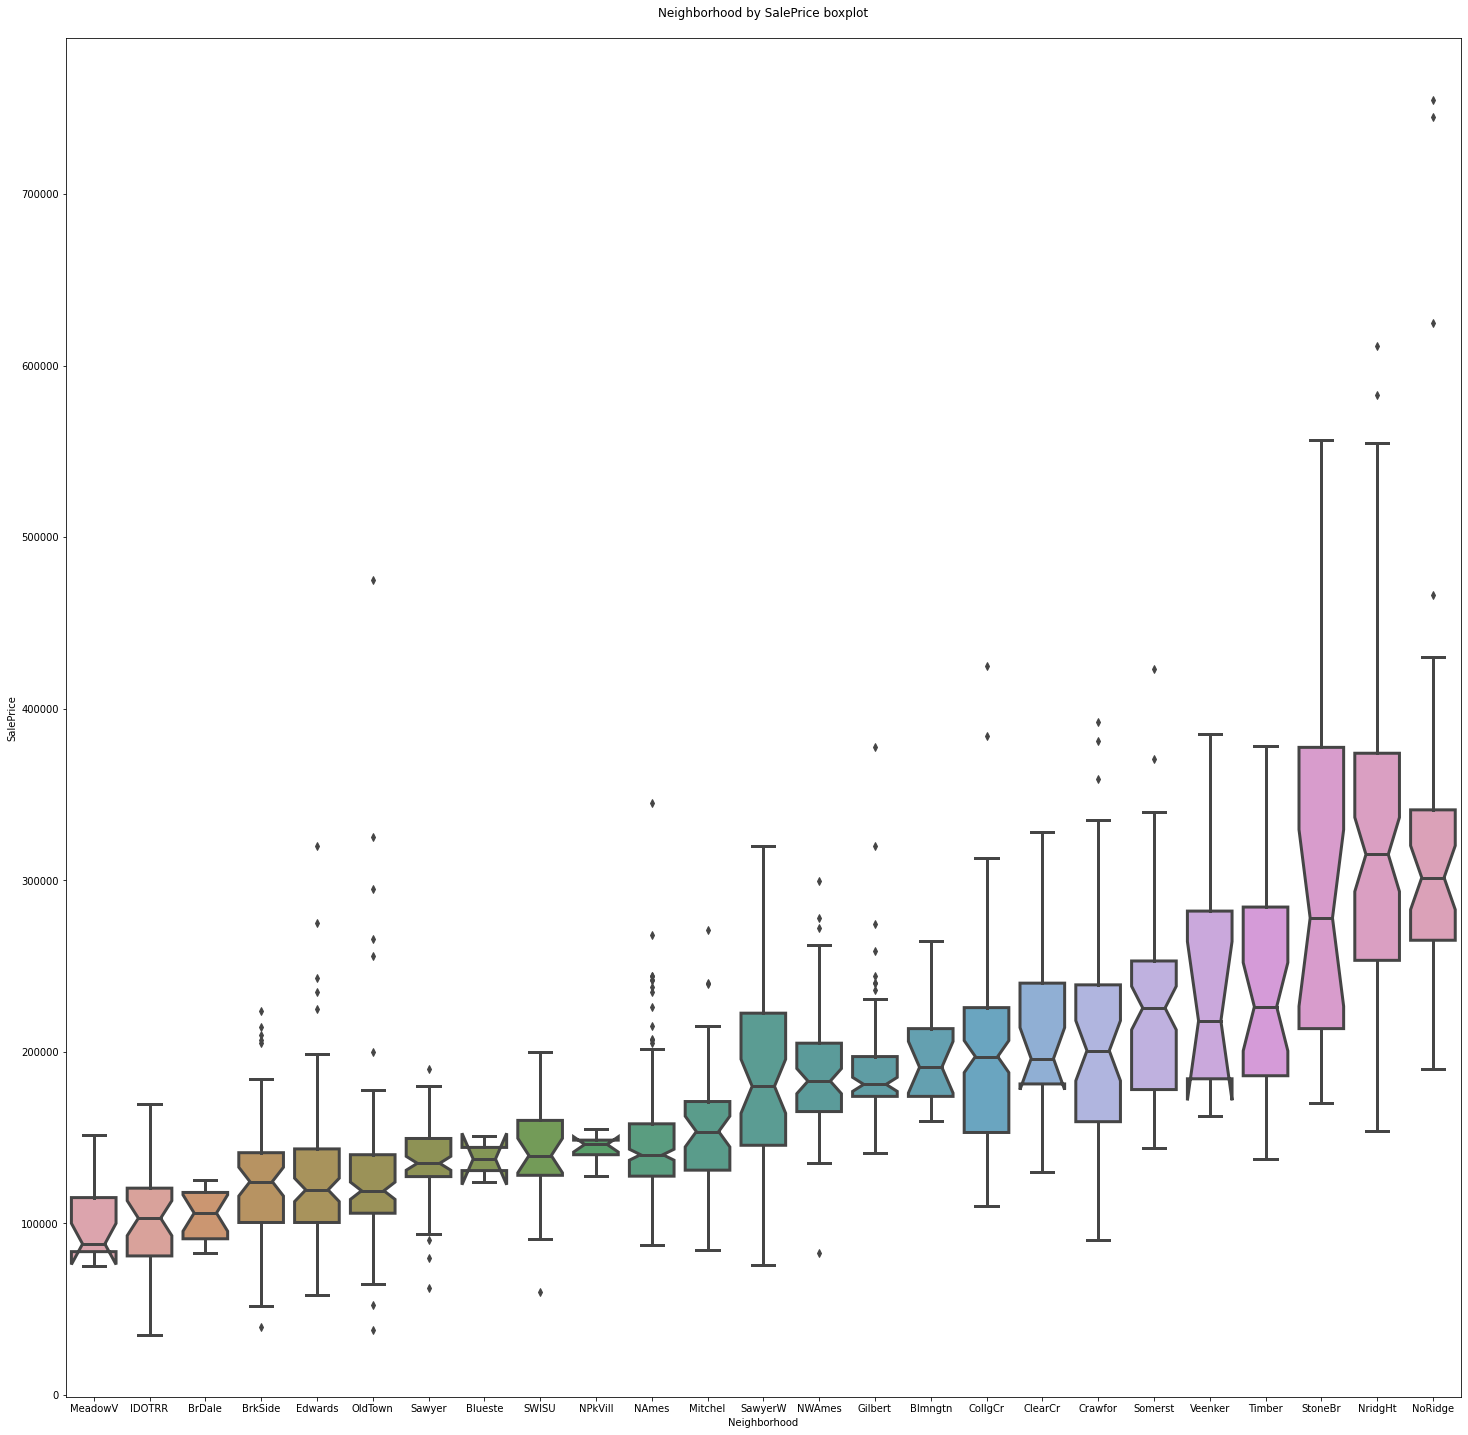

In [103]:
fig = plt.figure(figsize=(25,25))
ax = fig.gca()
ax = sns.boxplot(x ='Neighborhood', y ='SalePrice', data = df_train, fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax, order=neigh_order.index)
ax.set_title('Neighborhood by SalePrice boxplot\n')

It does seem as though OverallQual is a good potential predictor, but does not seem like Neighborhood is a good one. It intuitively makes sense that the neighborhood/location would affect the price, but there is a decent amount of variance in each, that makes it a poor predictor. Let's see if grouping them into an ordinal groups based off mean price will yield anything...

In [104]:
neighborhood = neigh_order.reset_index()
neighborhood['neighborhoodcat'] = pd.qcut(neighborhood['SalePrice'], q=4, labels=False).to_frame(name='cat')

In [105]:
df_train = df_train.merge(neighborhood[['Neighborhood', 'neighborhoodcat']], on='Neighborhood')

Text(0.5, 1.0, 'NeighborhoodCat by SalePrice boxplot\n')

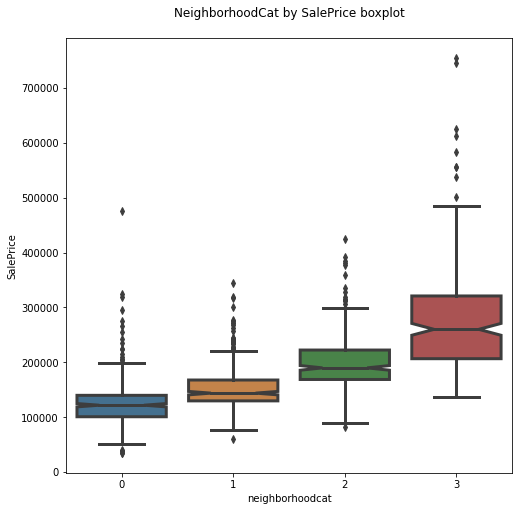

In [106]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax = sns.boxplot(x ='neighborhoodcat', y ='SalePrice', data = df_train, fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('NeighborhoodCat by SalePrice boxplot\n')

After breaking Neighborhoods into the different buckets, it looks like a viable option for a predictor.

In [107]:
# Potential Predictors

In [108]:
# Combine SF features to create Total SF
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']
# Combine Bathroom features to create Total Baths
df_train['TotalBaths'] = df_train['FullBath'] + df_train['BsmtFullBath'] + 0.5*(df_train['HalfBath'] + df_train['BsmtHalfBath'])

In [109]:
# Create consolidated DF
cols_combined = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath', 'Id']
df_train_cons = df_train.drop(cols_combined, axis=1)

Text(0.5, 1.0, 'Top Features by Correlation\n')

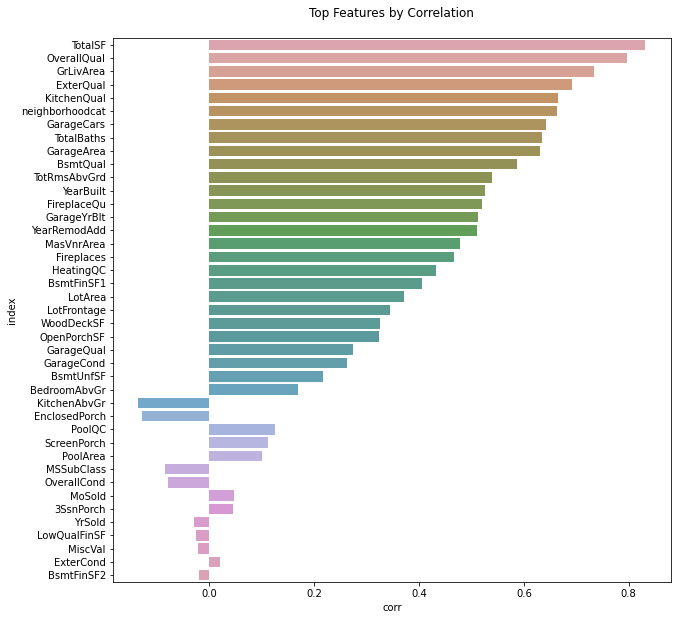

In [110]:
corr = df_train_cons.corr()['SalePrice'].sort_values(ascending=False).to_frame(name='corr').reset_index()
# Accounting for absolute value
corr_abs = corr.reindex(corr['corr'].abs().sort_values(ascending=False).index)
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax = sns.barplot(x='corr', y='index', data=corr_abs.drop(0), saturation=0.5, ax=ax)
ax.set_title('Top Features by Correlation\n')


In [111]:
corr[1:].head(10)

,index,corr
1,TotalSF,0.831937
2,OverallQual,0.797555
3,GrLivArea,0.734710
4,ExterQual,0.691047
5,KitchenQual,0.665293
6,neighborhoodcat,0.663329
7,GarageCars,0.642124
8,TotalBaths,0.634471
9,GarageArea,0.630382
10,BsmtQual,0.587134


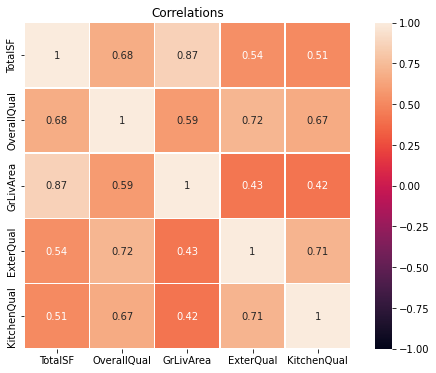

In [112]:
columns = ['TotalSF', 'OverallQual', 'GrLivArea', 'ExterQual', 'KitchenQual']
df_train_corr = df_train[columns]
df_train_corr.corr()

corrmat = df_train_corr.corr()

f, ax = plt.subplots(figsize = (9,6))
sns.heatmap(corrmat, vmin = -1, vmax = 1, square=True, annot = True, linewidths =.5)
plt.title('Correlations')

plt.show()

Based off the correlations above, it seems as though TotalSF, OverallQual, neighborhoodcat, GarageCars, and TotalBaths should potentially be considered as good predictors for SalePrice. The reason why GrLivArea, KitchenQual' and ExterQual were skipped over are because they are highly correlated with TotalSF and OverallQual respectively, and can lead to multicollinearity in the data.

#### **Transformation**

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, 

##### Dummy Variables

In [118]:
df_train_num.columns
str_cols = list(set(df_train.columns) - set(df_train_num.columns))
str_cols

['Exterior2nd',
 'Condition2',
 'PavedDrive',
 'MiscFeature',
 'BsmtFinType1',
 'Heating',
 'GarageFinish',
 'CentralAir',
 'Condition1',
 'Neighborhood',
 'BsmtExposure',
 'SaleType',
 'Foundation',
 'LandSlope',
 'LotShape',
 'MasVnrType',
 'RoofStyle',
 'Fence',
 'BsmtCond',
 'Street',
 'Alley',
 'RoofMatl',
 'MSZoning',
 'LandContour',
 'HouseStyle',
 'Utilities',
 'BldgType',
 'Electrical',
 'GarageType',
 'Functional',
 'BsmtFinType2',
 'SaleCondition',
 'LotConfig',
 'Exterior1st']

In [123]:
df_train['BsmtCond'].unique()

array(['TA', 'Gd', 'Fa', 'NA', 'Po'], dtype=object)

#### **Modeling**

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score